# 1. Importing Libraries

In [175]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, plot_confusion_matrix, PrecisionRecallDisplay, auc, make_scorer, matthews_corrcoef
from statsmodels.stats.diagnostic import lilliefors
import math
from feature_engine import transformation as vt
from matplotlib.colors import ListedColormap
from boruta import BorutaPy
from sklearn import tree
import plotly.express as px

# 2. Reading Data

In [176]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

In [177]:
#Row & Columns of Features 
X.shape

(1567, 590)

# 3. Splitting Training & Testing Data

In [178]:
#Splitting the Data: 80% Training, 20% Testing Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

In [179]:
#Rows and Columns of X_Train DF
x_train.shape

(1253, 590)

In [180]:
#Rows and Columns of X_Train DF
x_test.shape

(314, 590)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [181]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [182]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_duplicated_columns(x_train)
x_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [183]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [184]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_constant_volatility(x_train)
x_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [185]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [186]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_cols_with_high_pct_null(x_train, 0.7)
x_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

In [187]:
#Definition of Functiom
def outlier_clamp(df):
    for col in df.columns:
        ll_col = df[col].mean() - 2 * df[col].std()
        ul_col = df[col].mean() + 2 * df[col].std()
        df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

In [188]:
x_train = outlier_clamp(x_train)

In [189]:
#KNN only distance
def knndistance(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [190]:
x_train = knndistance(x_train)

In [191]:
#Function to drop Outliers and impute Missing Values with KNN 
def outlierknn(df):
    #Outlier treatment first:
    for col in df.columns:
          ll_col = df[col].mean() - 3 * df[col].std()
          ul_col = df[col].mean() + 3 * df[col].std()
          df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
    #Scaling data 
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [192]:
#Using function above on x_train
#x_train = outlierknn(x_train)

# 6. Feature Selection

In [193]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [194]:
#Using Boruta Shap on x_train
x_train = BorutaShap_FS(x_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [195]:
#RFE

#classifier = ['RF', 'SVM']

def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 30)
    rfe.fit(X_scaled,y)

     # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [196]:
#Using RFE on x_train
#x_train = RFE_FS(x_train, y_train, 'RF')

In [197]:
#Boruta function with random forest

def BorutaPy_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    ##--feature_selector.support_

    # check ranking of features
    ##--feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    # feature_ranks = list(zip(feature_names, 
    #                          feature_selector.ranking_, 
    #                          feature_selector.support_))

    # print the results
    ##--for feat in feature_ranks:
    ##--    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2) #change to 2
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    ##--print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features))

In [198]:
#Using BorutaPy_FS on x_train
#x_train = BorutaPy_FS(x_train, y_train)

In [199]:
#Shape of x_train after Feature Selection
x_train.shape

(1253, 18)

Text(0.5, 1.0, 'Correlation of remaining Features')

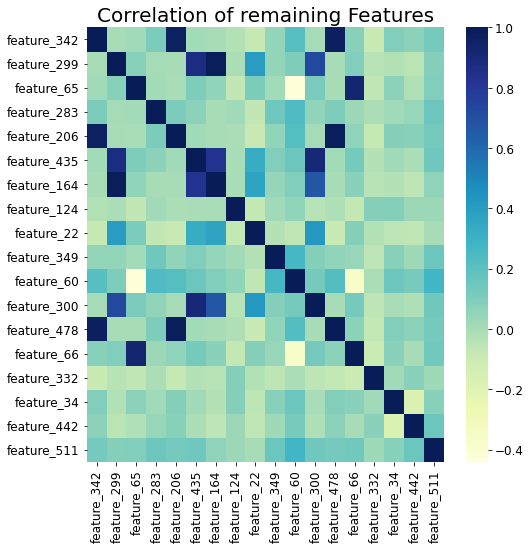

In [200]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 7. Multicolinearity Treatment

In [201]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [202]:
x_train=remove_collinear_features(x_train, 0.7)
x_train.shape

(1253, 12)

Text(0.5, 1.0, 'Correlation of remaining Features')

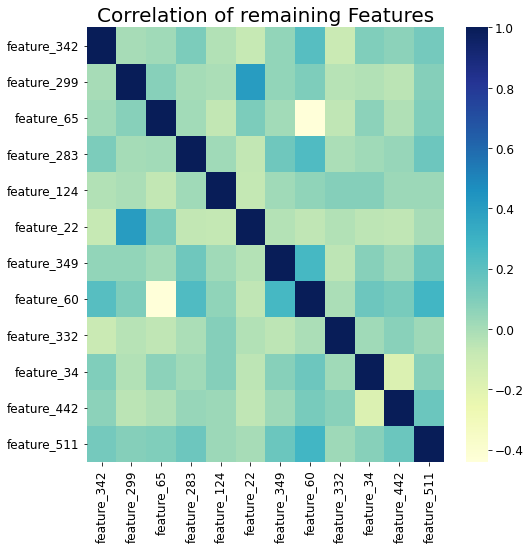

In [203]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

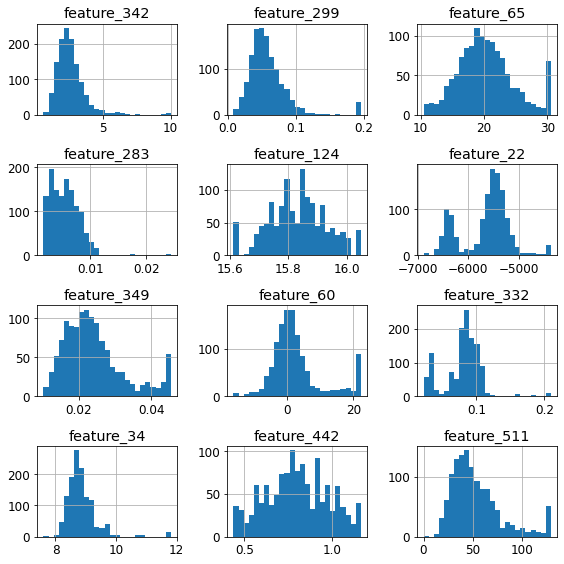

In [204]:
#Histograms remaining Features 
x_train.hist(bins=25)
plt.tight_layout()
plt.show()

In [205]:
#Normality Test
for i in x_train.columns:
    print(i)
    statistic, pvalue = lilliefors(x_train[[i]])
    print('statistic=%.3f, p=%.3f\n' % (statistic, pvalue))
    if pvalue > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

feature_342
statistic=0.094, p=0.001

Probably not Gaussian
feature_299
statistic=0.117, p=0.001

Probably not Gaussian
feature_65
statistic=0.047, p=0.001

Probably not Gaussian
feature_283
statistic=0.074, p=0.001

Probably not Gaussian
feature_124
statistic=0.045, p=0.001

Probably not Gaussian
feature_22
statistic=0.150, p=0.001

Probably not Gaussian
feature_349
statistic=0.102, p=0.001

Probably not Gaussian
feature_60
statistic=0.170, p=0.001

Probably not Gaussian
feature_332
statistic=0.157, p=0.001

Probably not Gaussian
feature_34
statistic=0.142, p=0.001

Probably not Gaussian
feature_442
statistic=0.037, p=0.001

Probably not Gaussian
feature_511
statistic=0.112, p=0.001

Probably not Gaussian


# 8. Balancing

In [206]:
#Function SMOTEENN
def sampling(X_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

In [207]:
x_train, y_train = sampling(x_train, y_train)

In [208]:
x_train.shape

(1552, 12)

In [209]:
y_train.shape

(1552,)

In [210]:
y_train.value_counts()

 1    867
-1    685
Name: status, dtype: int64

# 9. Modeling

In [211]:
#Turning y_train to categorical, since Naive Bayes works better on categorical data
y_train = pd.Categorical(y_train)
y_train = pd.DataFrame(y_train)

In [212]:
#Model and Model Evaluation
gnb = GaussianNB(var_smoothing=1)
gnb.fit(x_train, y_train)
# make predictions
expected = y_train
predicted = gnb.predict(x_train)
# summarize the fit of the gnb
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

          -1       0.62      0.27      0.38       685
           1       0.60      0.87      0.71       867

    accuracy                           0.60      1552
   macro avg       0.61      0.57      0.54      1552
weighted avg       0.61      0.60      0.56      1552

[[185 500]
 [115 752]]


In [213]:
#Sensitivity of Model
cf_matrix = confusion_matrix(expected, predicted)
sensitivity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
sensitivity

0.8673587081891581

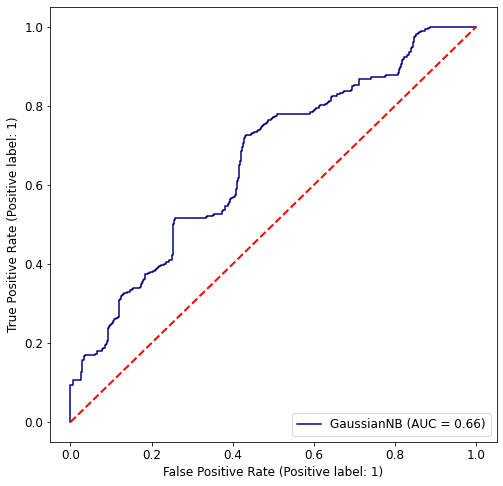

In [214]:
# ROC curve Train Data 
metrics.RocCurveDisplay.from_estimator(gnb, x_train, y_train, color="navy")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.show()

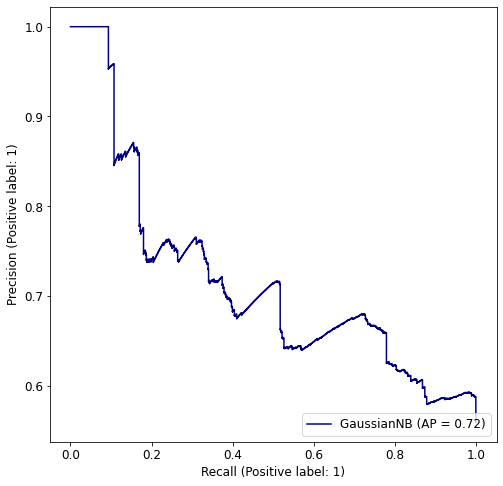

In [215]:
#Precision / Recall Train Data
metrics.PrecisionRecallDisplay.from_estimator(gnb, x_train, y_train, color="navy")
plt.legend(loc="lower right")
plt.show()

# 10. Test Data

In [216]:
#1. Remove Duplicated Columns 
x_test = remove_duplicated_columns(x_test)
x_test.shape

(314, 480)

In [217]:
#2. Remove Constant Volalitily
x_test = remove_constant_volatility(x_test)
x_test.shape

(314, 468)

In [218]:
#3. Remove High % of NA
x_test = remove_cols_with_high_pct_null(x_test, 0.7)
x_test.shape

(314, 460)

In [219]:
#4. Treat Outliers and Missing Values
## IF NA + KNN
#x_test= outlierknn(x_test)
## IF CLAMP + KNN
x_test = outlier_clamp(x_test)
x_test = knndistance(x_test)

In [220]:
#5. Take the same Columns as in train data 
columns_list = x_train.columns
x_test = x_test.loc[:,columns_list]
x_test.shape

(314, 12)

In [221]:
#6. Change Target Variable to Categorical
y_test = pd.Categorical(y_test)
y_test = pd.DataFrame(y_test)

In [222]:
y_test.value_counts()

-1    293
1      21
dtype: int64

In [223]:
exp_test = y_test
pred_test = gnb.predict(x_test)
# summarize the fit of the gnb
print(metrics.classification_report(exp_test, pred_test))
print(metrics.confusion_matrix(exp_test, pred_test))

              precision    recall  f1-score   support

          -1       0.92      0.24      0.38       293
           1       0.06      0.71      0.12        21

    accuracy                           0.27       314
   macro avg       0.49      0.48      0.25       314
weighted avg       0.86      0.27      0.36       314

[[ 70 223]
 [  6  15]]


In [224]:
cf_matrix_test = confusion_matrix(exp_test, pred_test)
sensitivity_test = cf_matrix_test[1][1] / ( cf_matrix_test[1][1] + cf_matrix_test[1][0] )
sensitivity_test

0.7142857142857143

In [225]:
#Accuracy score
accuracy_score(exp_test, pred_test)

0.27070063694267515

In [226]:
#Recall score
recall_score(exp_test, pred_test)

0.7142857142857143

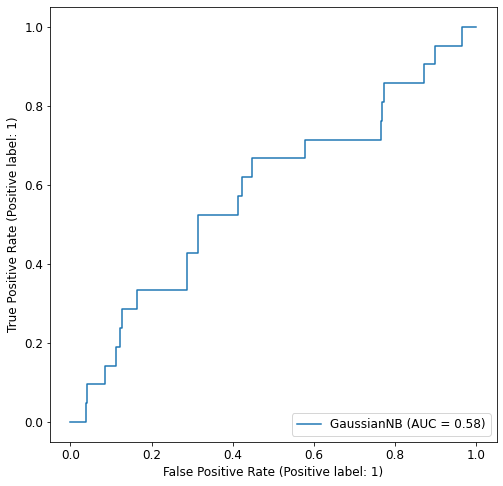

In [227]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(gnb, x_test, y_test)
plt.show()

# 11. Grid Search & Cross Validation

## 11.1. Grid Search

In [228]:
def mcc_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc

In [229]:
#Gridsearch
##Define Grid Search Parameters 
scoring = {"Accuracy": make_scorer(accuracy_score), "Recall" : make_scorer(recall_score), "Auc": make_scorer(roc_auc_score), "Precision": make_scorer(precision_score), "mcc" : make_scorer(mcc_score,greater_is_better=True)}
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
cv = StratifiedKFold(n_splits=5)
#Hyperparameter Tune using Training Data 
#nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10,  n_jobs=-1, scoring="roc_auc") #Best Sofar 
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=cv,  n_jobs=-1, scoring=scoring, refit="Auc")
nbModel_grid.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validatio

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e...
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             refit='Auc',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'Auc': make_scorer(roc_auc_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score),
                      'mcc': make_scorer(mcc_score)},
             verbose=1)

In [230]:
#Print Best estimator
print(nbModel_grid.best_estimator_, "is the best estimator")

GaussianNB(var_smoothing=2.848035868435799e-06) is the best estimator


In [231]:
#Data Frame Grid Search Results 
gridsearchNB = pd.DataFrame(nbModel_grid.cv_results_)
gridsearchNB.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,std_test_Precision,rank_test_Precision,split0_test_mcc,split1_test_mcc,split2_test_mcc,split3_test_mcc,split4_test_mcc,mean_test_mcc,std_test_mcc,rank_test_mcc
0,0.006535,0.004079,0.011799,0.002636,1.0,{'var_smoothing': 1.0},0.620579,0.614148,0.609677,0.609677,...,0.011625,100,0.217953,0.197834,0.188808,0.187367,0.088667,0.176126,0.045071,100
1,0.006323,0.007905,0.012775,0.006737,0.811131,{'var_smoothing': 0.8111308307896871},0.620579,0.614148,0.612903,0.612903,...,0.012108,99,0.217953,0.197834,0.196748,0.195015,0.088667,0.179243,0.046051,98
2,0.004576,0.001925,0.007237,0.002679,0.657933,{'var_smoothing': 0.657933224657568},0.620579,0.623794,0.612903,0.616129,...,0.013416,97,0.217953,0.221202,0.196748,0.202606,0.088667,0.185435,0.049241,91
3,0.004383,0.001968,0.006121,0.001561,0.53367,{'var_smoothing': 0.533669923120631},0.620579,0.627010,0.622581,0.616129,...,0.013392,92,0.217953,0.228852,0.220116,0.202606,0.097417,0.193389,0.048726,89
4,0.004090,0.000777,0.007894,0.004284,0.432876,{'var_smoothing': 0.43287612810830584},0.617363,0.627010,0.622581,0.612903,...,0.013203,96,0.208813,0.228852,0.220116,0.194976,0.097417,0.190035,0.047680,90


In [232]:
gridsearchNB.sort_values(by=['mean_test_Auc'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,std_test_Precision,rank_test_Precision,split0_test_mcc,split1_test_mcc,split2_test_mcc,split3_test_mcc,split4_test_mcc,mean_test_mcc,std_test_mcc,rank_test_mcc
61,0.001526,0.000242,0.010800,0.009366,0.000003,{'var_smoothing': 2.848035868435799e-06},0.742765,0.755627,0.751613,0.764516,...,0.016633,2,0.513004,0.534154,0.516253,0.556142,0.553677,0.534646,0.018062,1
60,0.001808,0.000944,0.006036,0.004613,0.000004,{'var_smoothing': 3.5111917342151275e-06},0.752412,0.755627,0.745161,0.764516,...,0.020099,1,0.533982,0.534154,0.505249,0.556142,0.540685,0.534042,0.016502,2
59,0.002334,0.001879,0.004292,0.000912,0.000004,{'var_smoothing': 4.328761281083053e-06},0.752412,0.755627,0.741935,0.761290,...,0.018876,3,0.533982,0.534154,0.499770,0.548286,0.540685,0.531376,0.016650,3
58,0.002696,0.002453,0.006961,0.004524,0.000005,{'var_smoothing': 5.336699231206313e-06},0.752412,0.755627,0.741935,0.761290,...,0.017827,4,0.533982,0.534154,0.499770,0.545789,0.540685,0.530876,0.016165,4
62,0.004536,0.004813,0.005197,0.002808,0.000002,{'var_smoothing': 2.310129700083158e-06},0.742765,0.749196,0.748387,0.764516,...,0.016537,7,0.513004,0.518738,0.510743,0.556142,0.553677,0.530461,0.020147,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,0.002608,0.001780,0.005486,0.002065,0.187382,{'var_smoothing': 0.1873817422860384},0.627010,0.610932,0.612903,0.606452,...,0.011726,93,0.229599,0.188609,0.194976,0.180169,0.106602,0.179991,0.040363,97
2,0.004576,0.001925,0.007237,0.002679,0.657933,{'var_smoothing': 0.657933224657568},0.620579,0.623794,0.612903,0.616129,...,0.013416,97,0.217953,0.221202,0.196748,0.202606,0.088667,0.185435,0.049241,91
5,0.003543,0.002381,0.004953,0.001047,0.351119,{'var_smoothing': 0.3511191734215131},0.617363,0.617363,0.616129,0.606452,...,0.011828,98,0.207858,0.204415,0.203617,0.179963,0.097417,0.178654,0.041811,99
1,0.006323,0.007905,0.012775,0.006737,0.811131,{'var_smoothing': 0.8111308307896871},0.620579,0.614148,0.612903,0.612903,...,0.012108,99,0.217953,0.197834,0.196748,0.195015,0.088667,0.179243,0.046051,98


In [233]:
gridsearchNB.sort_values(by=['mean_test_Auc'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,std_test_Precision,rank_test_Precision,split0_test_mcc,split1_test_mcc,split2_test_mcc,split3_test_mcc,split4_test_mcc,mean_test_mcc,std_test_mcc,rank_test_mcc
61,0.001526,0.000242,0.010800,0.009366,0.000003,{'var_smoothing': 2.848035868435799e-06},0.742765,0.755627,0.751613,0.764516,...,0.016633,2,0.513004,0.534154,0.516253,0.556142,0.553677,0.534646,0.018062,1
60,0.001808,0.000944,0.006036,0.004613,0.000004,{'var_smoothing': 3.5111917342151275e-06},0.752412,0.755627,0.745161,0.764516,...,0.020099,1,0.533982,0.534154,0.505249,0.556142,0.540685,0.534042,0.016502,2
59,0.002334,0.001879,0.004292,0.000912,0.000004,{'var_smoothing': 4.328761281083053e-06},0.752412,0.755627,0.741935,0.761290,...,0.018876,3,0.533982,0.534154,0.499770,0.548286,0.540685,0.531376,0.016650,3
58,0.002696,0.002453,0.006961,0.004524,0.000005,{'var_smoothing': 5.336699231206313e-06},0.752412,0.755627,0.741935,0.761290,...,0.017827,4,0.533982,0.534154,0.499770,0.545789,0.540685,0.530876,0.016165,4
62,0.004536,0.004813,0.005197,0.002808,0.000002,{'var_smoothing': 2.310129700083158e-06},0.742765,0.749196,0.748387,0.764516,...,0.016537,7,0.513004,0.518738,0.510743,0.556142,0.553677,0.530461,0.020147,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,0.002608,0.001780,0.005486,0.002065,0.187382,{'var_smoothing': 0.1873817422860384},0.627010,0.610932,0.612903,0.606452,...,0.011726,93,0.229599,0.188609,0.194976,0.180169,0.106602,0.179991,0.040363,97
2,0.004576,0.001925,0.007237,0.002679,0.657933,{'var_smoothing': 0.657933224657568},0.620579,0.623794,0.612903,0.616129,...,0.013416,97,0.217953,0.221202,0.196748,0.202606,0.088667,0.185435,0.049241,91
5,0.003543,0.002381,0.004953,0.001047,0.351119,{'var_smoothing': 0.3511191734215131},0.617363,0.617363,0.616129,0.606452,...,0.011828,98,0.207858,0.204415,0.203617,0.179963,0.097417,0.178654,0.041811,99
1,0.006323,0.007905,0.012775,0.006737,0.811131,{'var_smoothing': 0.8111308307896871},0.620579,0.614148,0.612903,0.612903,...,0.012108,99,0.217953,0.197834,0.196748,0.195015,0.088667,0.179243,0.046051,98


In [234]:
#Overview of Columns in Gridsearchresults 
gridsearchNB.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_var_smoothing', 'params', 'split0_test_Accuracy',
       'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy',
       'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy',
       'rank_test_Accuracy', 'split0_test_Recall', 'split1_test_Recall',
       'split2_test_Recall', 'split3_test_Recall', 'split4_test_Recall',
       'mean_test_Recall', 'std_test_Recall', 'rank_test_Recall',
       'split0_test_Auc', 'split1_test_Auc', 'split2_test_Auc',
       'split3_test_Auc', 'split4_test_Auc', 'mean_test_Auc', 'std_test_Auc',
       'rank_test_Auc', 'split0_test_Precision', 'split1_test_Precision',
       'split2_test_Precision', 'split3_test_Precision',
       'split4_test_Precision', 'mean_test_Precision', 'std_test_Precision',
       'rank_test_Precision', 'split0_test_mcc', 'split1_test_mcc',
       'split2_test_mcc', 'split3_test_mcc', 'split4_test_mcc',
       'mean

In [235]:
#Calculating Cost
cl_list = ['param_var_smoothing','mean_test_Precision', 'mean_test_Recall', 'mean_test_Accuracy']
cost_df = gridsearchNB.loc[:, cl_list]
cost_df['type2_error'] = cost_df['mean_test_Recall'].apply(lambda x: 21 - (21 * x))
cost_df['type2_error'] = cost_df['type2_error'] #.round(decimals = 0 )
cost_df['type1_error'] = cost_df.apply(lambda row: ((21 - row.type2_error) / row.mean_test_Precision) - (21-row.type2_error), axis=1)
cost_df['type1_error'] = cost_df['type1_error'] #.round(decimals = 0 )
cost_df['costs'] = cost_df.apply(lambda row: row.type2_error * 10 + row.type1_error, axis=1)
cost_df

,param_var_smoothing,mean_test_Precision,mean_test_Recall,mean_test_Accuracy,type2_error,type1_error,costs
0,1.0,0.601702,0.867311,0.605010,2.786466,12.056480,39.921140
1,0.811131,0.602701,0.867311,0.606300,2.786466,12.006293,39.870953
2,0.657933,0.604697,0.867311,0.608875,2.786466,11.906572,39.771232
3,0.53367,0.607134,0.867311,0.612098,2.786466,11.785676,39.650337
4,0.432876,0.606501,0.865006,0.610810,2.834881,11.785565,40.134379
...,...,...,...,...,...,...,...
95,0.0,0.843944,0.660946,0.741628,7.120132,2.566561,73.767876
96,0.0,0.844193,0.662102,0.742274,7.095854,2.566190,73.524731
97,0.0,0.842753,0.655186,0.738409,7.241100,2.567230,74.978233
98,0.0,0.842288,0.654036,0.737766,7.265238,2.571721,75.224103


In [236]:
cost_df.to_excel("output.xlsx")  

In [237]:
#3D Scatter Costs, Recall & Var_smoothing
fig = px.scatter_3d(cost_df, z='costs', y='mean_test_Recall', x='mean_test_Precision', color='costs', size='costs')
fig.show()

In [238]:
#3D Scatter Costs, Recall & Var_smoothing
fig = plt.figure(figsize=(20, 20))
fig = px.scatter_3d(cost_df, z='param_var_smoothing', x='mean_test_Recall', y='mean_test_Precision',
                    labels={"param_var_smoothing": "Hyperparameter",
                            "mean_test_Recall": "Recall",
                            "mean_test_Precision": "Precision"},
                        color='costs', size='costs'
                        )
fig.show()

<Figure size 1440x1440 with 0 Axes>

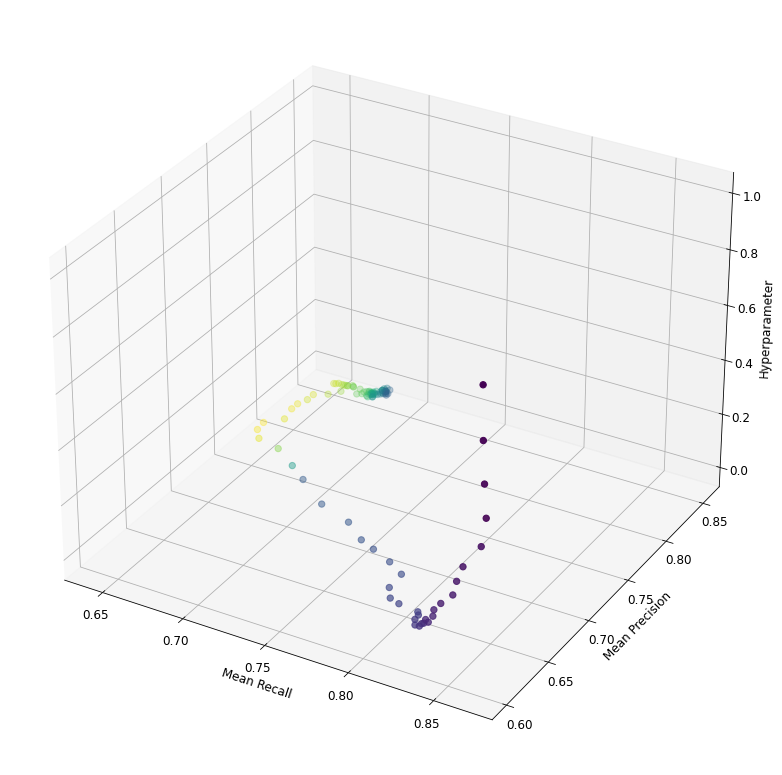

In [239]:
#3D Scatter Point var_smoothing, accuracy & Recall
fig = plt.figure(figsize=(16, 14))
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(projection='3d')

z,y,x = gridsearchNB.param_var_smoothing, gridsearchNB.mean_test_Precision, gridsearchNB.mean_test_Recall
ax.set_zlabel('Hyperparameter')
ax.set_xlabel('Mean Recall')
ax.set_ylabel('Mean Precision')
ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=gridsearchNB.rank_test_Recall)
plt.show()

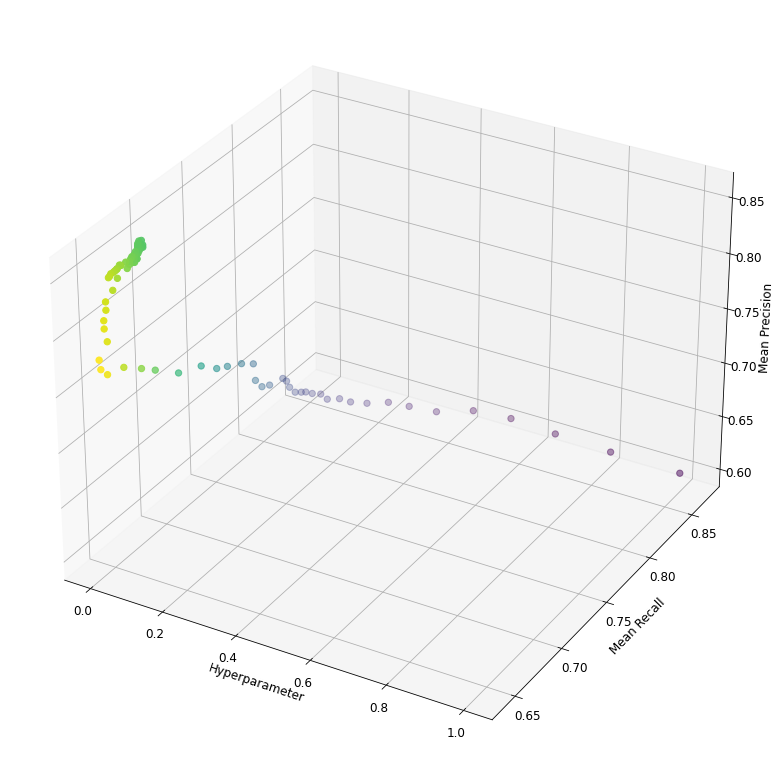

In [240]:
#3D Scatter Point Costs , accuracy & Recall
fig = plt.figure(figsize=(16, 14))
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(projection='3d')

x,z,y = cost_df.param_var_smoothing, cost_df.mean_test_Precision, cost_df.mean_test_Recall
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('Mean Recall')
ax.set_zlabel('Mean Precision')
ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=cost_df.costs)
plt.show()

<AxesSubplot:xlabel='mean_test_Recall', ylabel='mean_test_Accuracy'>

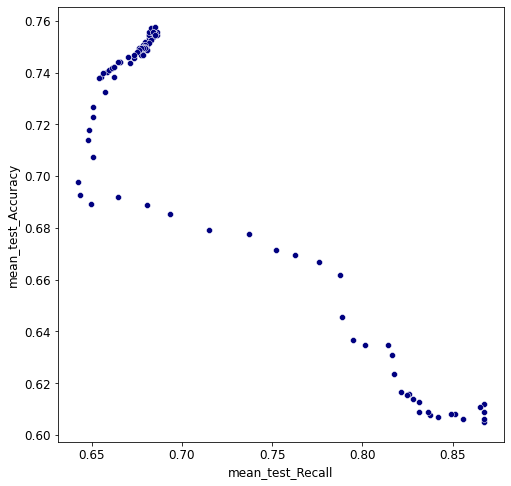

In [241]:
#Crossvalidation Vizualization Recall & Acccuracy
sns.scatterplot(data=cost_df, y='mean_test_Accuracy', x='mean_test_Recall', color="navy")

## 11.2. Cross Validation

In [242]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=20)
print("mean Recall")
scores = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'recall')
print(scores.mean())
print("mean accuracy")
accuracycv = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'accuracy') 
print(accuracycv.mean())
print("mean auc")
auccv = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'roc_auc') 
print(auccv.mean())
print("mean precision")
preccv = cross_val_score(nbModel_grid.best_estimator_, x_train, y_train, cv=cv, scoring = 'precision') 
print(preccv.mean())
# fit
#nb=nbModel_grid.best_estimator_.fit(x_train, y_train)    
nb=GaussianNB(var_smoothing=1.0)
nb.fit(x_train, y_train)
# predict
y_pred_test = nb.predict(x_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)
# View accuracy score
RecallFinal = recall_score(y_test, y_pred_test)
print('Test Recall : ', RecallFinal)
PrecisionFinal = precision_score(y_test, y_pred_test)
print('Test Precision : ', PrecisionFinal)

mean Recall
0.6827959830866807
mean accuracy
0.7564851814851814
mean auc
0.8219953763746514
mean precision
0.8537977993271181
Test Accuracy :  0.27070063694267515
Test Recall :  0.7142857142857143
Test Precision :  0.06302521008403361


In [243]:
scores_df = pd.DataFrame(scores, columns=['recall_scores'])
acc_df = pd.DataFrame(accuracycv, columns=['accuracy_scores'])
auc_df = pd.DataFrame(auccv, columns = ['auc_scores'])
prec_df =pd.DataFrame(preccv, columns = ['precision_scores']) 
cv_scores_df = pd.concat([scores_df, acc_df, auc_df, prec_df], axis=1)
cv_scores_df['type2_error'] = cv_scores_df['recall_scores'].apply(lambda x: 21 - (21 * x))
cv_scores_df['type2_error'] = cv_scores_df['type2_error'].round(decimals = 0 )
cv_scores_df['type1_error'] = cv_scores_df.apply(lambda row: ((21 - row.type2_error) / row.precision_scores) - (21-row.type2_error), axis=1)
cv_scores_df['type1_error'] = cv_scores_df['type1_error'].round(decimals = 0 )
cv_scores_df['costs'] = cv_scores_df.apply(lambda row: row.type2_error * 10 + row.type1_error, axis=1)
cv_scores_df

,recall_scores,accuracy_scores,auc_scores,precision_scores,type2_error,type1_error,costs
0,0.627907,0.730769,0.789369,0.843750,8.0,2.0,82.0
1,0.627907,0.743590,0.798007,0.870968,8.0,2.0,82.0
2,0.674419,0.743590,0.854485,0.828571,7.0,3.0,73.0
3,0.697674,0.794872,0.865781,0.909091,6.0,2.0,62.0
4,0.627907,0.743590,0.843854,0.870968,8.0,2.0,82.0
5,0.750000,0.769231,0.816176,0.825000,5.0,3.0,53.0
6,0.681818,0.769231,0.847594,0.882353,7.0,2.0,72.0
7,0.636364,0.730769,0.840909,0.848485,8.0,2.0,82.0
8,0.704545,0.743590,0.784759,0.815789,6.0,3.0,63.0
9,0.613636,0.705128,0.817513,0.818182,8.0,3.0,83.0


<AxesSubplot:xlabel='recall_scores', ylabel='precision_scores'>

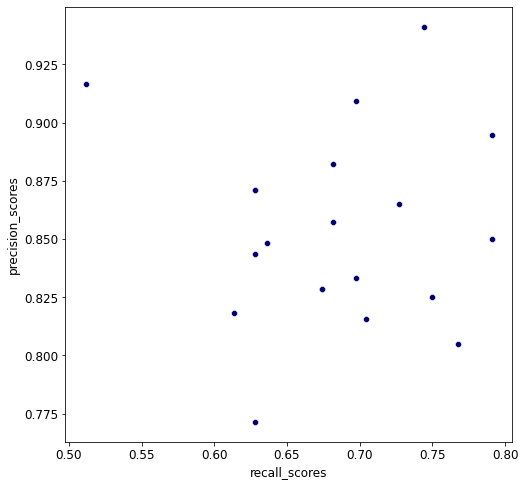

In [244]:
#Crossvalidation Vizualization Recall & Acccuracy
sns.scatterplot(data=cv_scores_df, x='recall_scores', y='precision_scores', color="navy")

In [245]:
#Confusion Matrix & Classification Report of best estimator
print(metrics.confusion_matrix(y_test, y_pred_test))
print(metrics.classification_report(y_test, y_pred_test))

[[ 70 223]
 [  6  15]]
              precision    recall  f1-score   support

          -1       0.92      0.24      0.38       293
           1       0.06      0.71      0.12        21

    accuracy                           0.27       314
   macro avg       0.49      0.48      0.25       314
weighted avg       0.86      0.27      0.36       314



In [246]:
cf_matrix_test_best = metrics.confusion_matrix(y_test, y_pred_test)
print(cf_matrix_test_best)
print(cf_matrix_test_best[1][0])
#sensitivity_test = cf_matrix_test[1][1] / ( cf_matrix_test[1][1] + cf_matrix_test[1][0] )

[[ 70 223]
 [  6  15]]
6


In [247]:
f1_score(y_test,y_pred_test)

0.11583011583011583

In [248]:
precision_score(y_test, y_pred_test)

0.06302521008403361

In [249]:
recall_score(y_test, y_pred_test)

0.7142857142857143

In [250]:
roc_auc_score(y_test, y_pred_test)

0.476596782057533

In [251]:
auc = roc_auc_score(y_test, y_pred_test)
GINI = (2 * auc) - 1
print(GINI)

-0.04680643588493405


In [252]:
f1_score(y_test, y_pred_test)

0.11583011583011583

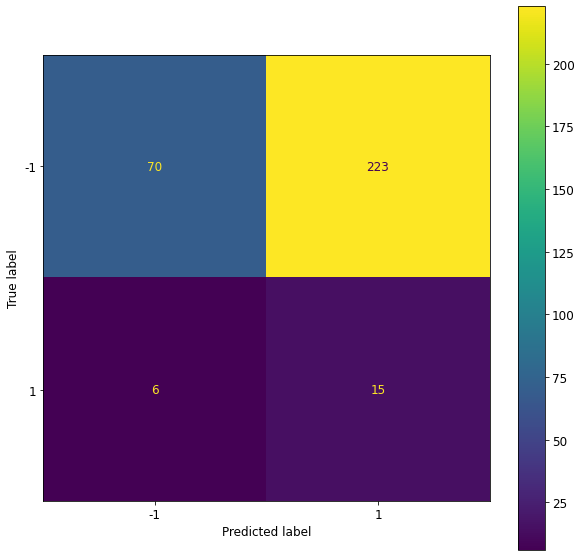

In [253]:
# Plot confussion matrix
plt.rcParams['figure.figsize'] = (10, 10)
cm = confusion_matrix(y_test, y_pred_test, labels=nbModel_grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nbModel_grid.best_estimator_.classes_)
disp.plot()
plt.show()

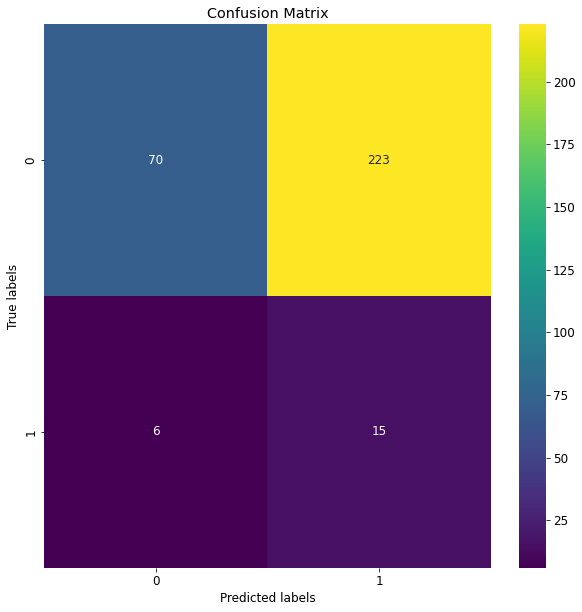

In [254]:
ax= plt.subplot()
plt.rcParams['figure.figsize'] = (8, 10)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='viridis')  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['Faulty wafers', 'Admissable wafer']); ax.yaxis.set_ticklabels(['Admissable wafer','Faulty wafers']); 
plt.show()

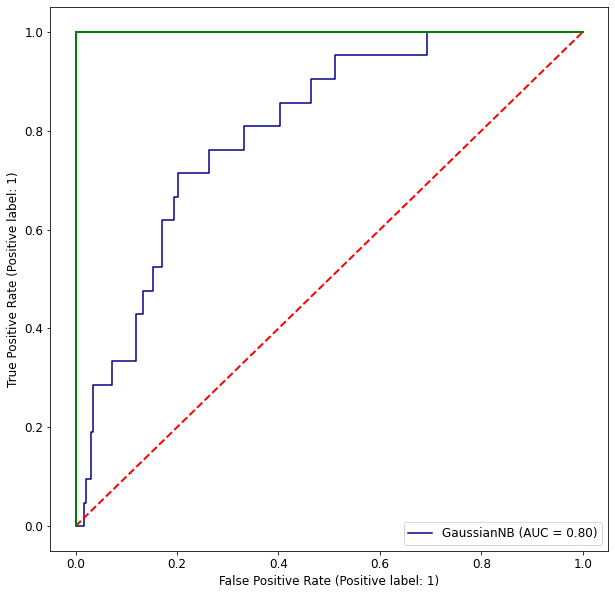

In [255]:
# ROC curve
plt.rcParams['figure.figsize'] = (10, 10)
metrics.RocCurveDisplay.from_estimator(nbModel_grid.best_estimator_, x_test, y_test, color="navy")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.plot([0, 0], [1, 0], color="green", lw=2, linestyle="-")
plt.plot([1, 0], [1, 1], color="green", lw=2, linestyle="-")
plt.show()

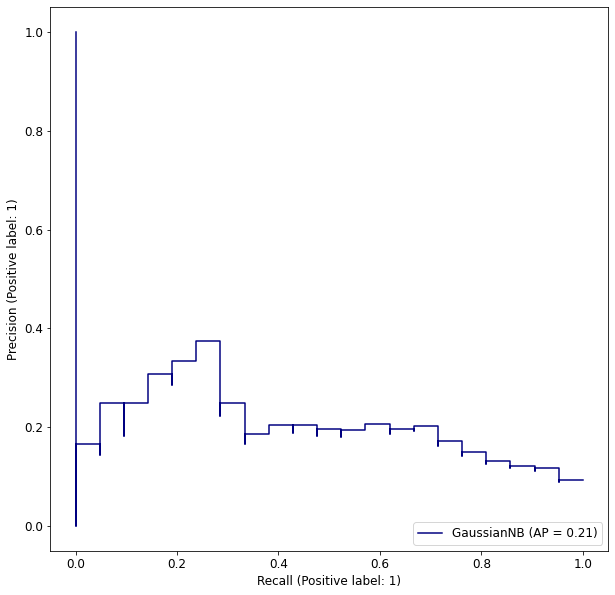

In [256]:
#Precision / Recall
metrics.PrecisionRecallDisplay.from_estimator(nbModel_grid.best_estimator_, x_test, y_test, color="navy")
plt.legend(loc="lower right")
plt.show()

TypeError: 'numpy.float64' object is not callable

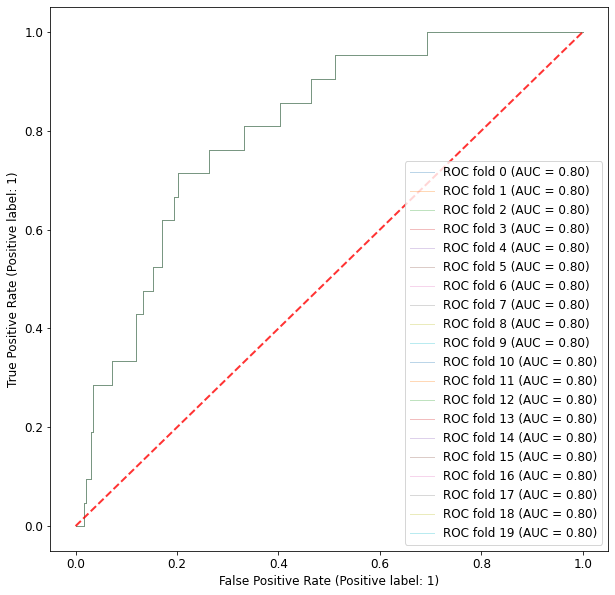

In [257]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(x_train, y_train)):
    nbModel_grid.best_estimator_.fit(x_train, y_train)
    viz = metrics.RocCurveDisplay.from_estimator(
        nbModel_grid.best_estimator_,
        x_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05]
)
ax.legend(loc="lower right")
plt.show()    